In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot as plt

Fix random seed

In [2]:
import random
# Set the seed for Python's built-in random module
random_seed = 42
random.seed(random_seed)

# Set the seed for NumPy
np.random.seed(random_seed)

# Set the seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Loading Dataset

11490434/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


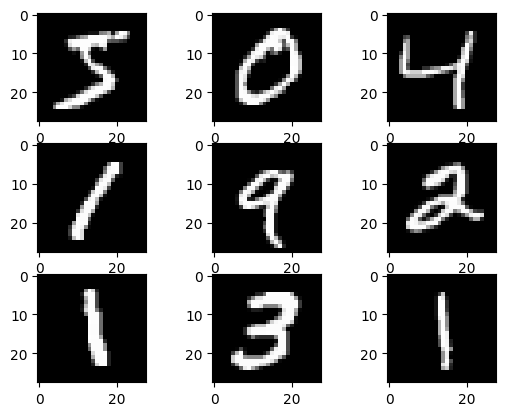

In [3]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# print shape
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
 plt.subplot(330 + 1 + i)
 plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))

plt.show()

### Preprocessing

In [4]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


### Create a CNN Model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        #10 numbers
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x) #1 -> 32
        x = F.relu(x)

        x = self.conv2(x) #32 -> 32
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x) #32 -> 64
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [ ]:
# Instantiate the model
model = CNN()

# Move the model to a specific device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Display the model summary
summary(model, (1, 28, 28))  # Assuming input size is (1, 28, 28), adjust accordingly


### Fitting model

In [5]:
def fit(model, optimizer, train_loader):
    # Use GPU to train
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    EPOCHS = 20
    model.train()
    loss_values = []

    for epoch in range(EPOCHS):
        correct = 0
        running_loss = 0.0
        total_samples = 0

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1)
            total_samples += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        accuracy = correct / total_samples
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)

        print('[Epoch %d] Loss: %.3f, Accuracy: %.3f' % (epoch + 1, epoch_loss, accuracy))

    return loss_values


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_adam = CNN().to(device)
Adam = torch.optim.Adam(cnn_adam.parameters(), lr=5e-4, betas=(0.9, 0.999))
Adam_model = fit(cnn_adam, Adam, train_loader)

[Epoch 1] Loss: 0.437, Accuracy: 0.868
[Epoch 2] Loss: 0.156, Accuracy: 0.954
[Epoch 3] Loss: 0.125, Accuracy: 0.964
[Epoch 4] Loss: 0.114, Accuracy: 0.967
[Epoch 5] Loss: 0.105, Accuracy: 0.970
[Epoch 6] Loss: 0.099, Accuracy: 0.972
[Epoch 7] Loss: 0.093, Accuracy: 0.973
[Epoch 8] Loss: 0.094, Accuracy: 0.974
[Epoch 9] Loss: 0.089, Accuracy: 0.975
[Epoch 10] Loss: 0.087, Accuracy: 0.975
[Epoch 11] Loss: 0.084, Accuracy: 0.976
[Epoch 12] Loss: 0.081, Accuracy: 0.977
[Epoch 13] Loss: 0.083, Accuracy: 0.977
[Epoch 14] Loss: 0.081, Accuracy: 0.977
[Epoch 15] Loss: 0.078, Accuracy: 0.979
[Epoch 16] Loss: 0.080, Accuracy: 0.978
[Epoch 17] Loss: 0.077, Accuracy: 0.979
[Epoch 18] Loss: 0.076, Accuracy: 0.979
[Epoch 19] Loss: 0.079, Accuracy: 0.978
[Epoch 20] Loss: 0.076, Accuracy: 0.979


Training SGD

In [38]:
cnn_sgd = CNN().to(device)
SGD_optimizer = torch.optim.SGD(cnn_sgd.parameters(), lr=5e-4)
SGD_model = fit(cnn_sgd, SGD_optimizer, train_loader)

[Epoch 1] Loss: 1.681, Accuracy: 0.412
[Epoch 2] Loss: 0.658, Accuracy: 0.785
[Epoch 3] Loss: 0.428, Accuracy: 0.864
[Epoch 4] Loss: 0.345, Accuracy: 0.893
[Epoch 5] Loss: 0.299, Accuracy: 0.907
[Epoch 6] Loss: 0.269, Accuracy: 0.916
[Epoch 7] Loss: 0.242, Accuracy: 0.925
[Epoch 8] Loss: 0.225, Accuracy: 0.931
[Epoch 9] Loss: 0.210, Accuracy: 0.935
[Epoch 10] Loss: 0.199, Accuracy: 0.939
[Epoch 11] Loss: 0.190, Accuracy: 0.941
[Epoch 12] Loss: 0.179, Accuracy: 0.945
[Epoch 13] Loss: 0.168, Accuracy: 0.948
[Epoch 14] Loss: 0.164, Accuracy: 0.950
[Epoch 15] Loss: 0.158, Accuracy: 0.952
[Epoch 16] Loss: 0.153, Accuracy: 0.954
[Epoch 17] Loss: 0.145, Accuracy: 0.955
[Epoch 18] Loss: 0.142, Accuracy: 0.958
[Epoch 19] Loss: 0.141, Accuracy: 0.957
[Epoch 20] Loss: 0.135, Accuracy: 0.959


Training a couple more popular Alg to compare

Adagrad

In [39]:
cnn_Adagrad = CNN().to(device)
Adagrad = torch.optim.Adagrad(cnn_Adagrad.parameters(), lr=5e-4)
Adagrad_model = fit(cnn_Adagrad, Adagrad, train_loader)

[Epoch 1] Loss: 1.455, Accuracy: 0.519
[Epoch 2] Loss: 0.677, Accuracy: 0.780
[Epoch 3] Loss: 0.524, Accuracy: 0.832
[Epoch 4] Loss: 0.446, Accuracy: 0.860
[Epoch 5] Loss: 0.396, Accuracy: 0.876
[Epoch 6] Loss: 0.361, Accuracy: 0.888
[Epoch 7] Loss: 0.328, Accuracy: 0.898
[Epoch 8] Loss: 0.307, Accuracy: 0.906
[Epoch 9] Loss: 0.294, Accuracy: 0.909
[Epoch 10] Loss: 0.274, Accuracy: 0.915
[Epoch 11] Loss: 0.270, Accuracy: 0.917
[Epoch 12] Loss: 0.257, Accuracy: 0.921
[Epoch 13] Loss: 0.248, Accuracy: 0.924
[Epoch 14] Loss: 0.238, Accuracy: 0.927
[Epoch 15] Loss: 0.231, Accuracy: 0.929
[Epoch 16] Loss: 0.224, Accuracy: 0.931
[Epoch 17] Loss: 0.218, Accuracy: 0.933
[Epoch 18] Loss: 0.212, Accuracy: 0.934
[Epoch 19] Loss: 0.209, Accuracy: 0.938
[Epoch 20] Loss: 0.201, Accuracy: 0.939


RMSprop

In [40]:
cnn_RMSprop = CNN().to(device)
RMSprop = torch.optim.RMSprop(cnn_RMSprop.parameters(), lr=5e-4)
RMSprop_model = fit(cnn_RMSprop, RMSprop, train_loader)

[Epoch 1] Loss: 0.353, Accuracy: 0.895
[Epoch 2] Loss: 0.138, Accuracy: 0.959
[Epoch 3] Loss: 0.116, Accuracy: 0.967
[Epoch 4] Loss: 0.102, Accuracy: 0.971
[Epoch 5] Loss: 0.103, Accuracy: 0.972
[Epoch 6] Loss: 0.093, Accuracy: 0.975
[Epoch 7] Loss: 0.092, Accuracy: 0.975
[Epoch 8] Loss: 0.090, Accuracy: 0.976
[Epoch 9] Loss: 0.088, Accuracy: 0.976
[Epoch 10] Loss: 0.087, Accuracy: 0.977
[Epoch 11] Loss: 0.087, Accuracy: 0.977
[Epoch 12] Loss: 0.090, Accuracy: 0.976
[Epoch 13] Loss: 0.091, Accuracy: 0.977
[Epoch 14] Loss: 0.086, Accuracy: 0.977
[Epoch 15] Loss: 0.088, Accuracy: 0.976
[Epoch 16] Loss: 0.089, Accuracy: 0.977
[Epoch 17] Loss: 0.091, Accuracy: 0.977
[Epoch 18] Loss: 0.092, Accuracy: 0.977
[Epoch 19] Loss: 0.093, Accuracy: 0.976
[Epoch 20] Loss: 0.092, Accuracy: 0.977


L-BFGS (Approximate Hessian)  \
will not converge as expect (BFGS does not scale well on large dataset)

In [6]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super(Simple_CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.fc = nn.Linear(64 * 2 * 2, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))

        x = self.flatten(x)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)


In [11]:
from torchsummary import summary

# Instantiate the model
cnn_LBFGS = Simple_CNN()

# Move the model to a specific device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_LBFGS.to(device)

# Display the model summary
summary(cnn_LBFGS, (1, 28, 28))  # Assuming input size is (1, 28, 28), adjust accordingly


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         MaxPool2d-2             [-1, 32, 9, 9]               0
            Conv2d-3             [-1, 64, 5, 5]          51,264
         MaxPool2d-4             [-1, 64, 2, 2]               0
           Flatten-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 54,666
Trainable params: 54,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.21
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


In [ ]:
LBFGS = torch.optim.LBFGS(cnn_LBFGS.parameters(),lr=0.05,max_iter=7, history_size=20,line_search_fn='strong_wolfe')#

criterion = nn.CrossEntropyLoss()
epochs = 20
LBFGS_loss = []

for epoch in range(epochs):
    running_loss = 0.0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)

      def closure():
        # Zero gradients
        LBFGS.zero_grad()
        y_pred = cnn_LBFGS(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        return loss

      LBFGS.step(closure)
      loss = closure()
      running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    LBFGS_loss.append(epoch_loss)

    print('[Epoch %d] Loss: %.3f' % (epoch + 1, epoch_loss))

[Epoch 1] Loss: 0.118
[Epoch 2] Loss: 0.127
[Epoch 3] Loss: 0.142
[Epoch 4] Loss: 0.135
[Epoch 5] Loss: 0.137
[Epoch 6] Loss: 0.125
[Epoch 7] Loss: 0.144
[Epoch 8] Loss: 0.127
[Epoch 9] Loss: 0.131
[Epoch 10] Loss: 0.141
[Epoch 11] Loss: 0.150
[Epoch 12] Loss: 0.152
[Epoch 13] Loss: 0.143
[Epoch 14] Loss: 0.160
[Epoch 15] Loss: 0.176


Plot Training Loss

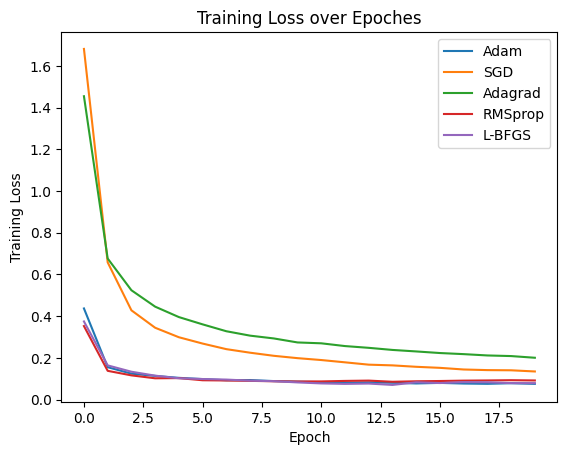

In [41]:
plt.plot(Adam_model, label='Adam')
plt.plot(SGD_model,label='SGD')
plt.plot(Adagrad_model,label='Adagrad')
plt.plot(RMSprop_model,label='RMSprop')
plt.plot(LBFGS_loss,label='L-BFGS')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epoches')
plt.legend()
plt.show()

In [43]:
def evaluate(model):
  model.eval()
  correct = 0

  with torch.no_grad():
    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        #calculate accuracy
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()

    accuracy = correct / (len(test_loader.dataset))
    print("Accuracy: {:.3f}%".format(accuracy * 100))


In [49]:
evaluate(cnn_adam)


Accuracy: 99.220%


In [50]:
evaluate(cnn_sgd)

Accuracy: 98.460%


In [47]:
evaluate(cnn_RMSprop)

Accuracy: 98.750%


In [46]:
evaluate(cnn_Adagrad)

Accuracy: 97.830%


In [45]:
evaluate(cnn_LBFGS)

Accuracy: 96.170%
